In [1]:
import numpy as np

import matplotlib as mpl

from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image

In [150]:
import pandas as pd

In [201]:
import tensorflow as tf
from tensorflow import keras

In [28]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
path="E:\Python_Training\Kaggle\Pollen_bee_classification\honey-bee-pollen\PollenDataset\images"

imlist= glob.glob(os.path.join(path, '*.jpg'))

In [39]:
def dataset(file_list,size=(300,180),flattened=False):
	data = []
	for i, file in enumerate(file_list):
		image = io.imread(file)
		image = transform.resize(image, size, mode='constant')
		if flattened:
			image = image.flatten()

		data.append(image)

	labels = [1 if f.split("\\")[-1][0] == 'P' else 0 for f in file_list]

	return np.array(data), np.array(labels)

In [235]:
X,y=dataset(imlist)

In [236]:
print('The length of X: ',len(X))  # data
print('The shape of X: ',X.shape)  # target
print('The shape of Y', y.shape)


The length of X:  714
The shape of X:  (714, 300, 180, 3)
The shape of Y (714,)


In [237]:
img=imlist[0]

In [238]:
img

'E:\\Python_Training\\Kaggle\\Pollen_bee_classification\\honey-bee-pollen\\PollenDataset\\images\\NP10057-126r.jpg'

In [239]:
img.split("\\")

['E:',
 'Python_Training',
 'Kaggle',
 'Pollen_bee_classification',
 'honey-bee-pollen',
 'PollenDataset',
 'images',
 'NP10057-126r.jpg']

In [240]:
img.split("\\")[-1][0]

'N'

In [241]:
def show(img):
  plt.figure(figsize=(12,12))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

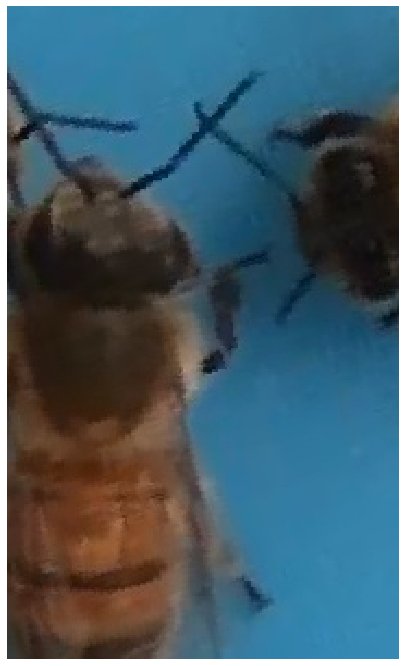

In [242]:
show(X[5])

In [243]:
# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

In [232]:
for i in range(0, X.shape[0]):
    X[i]=deprocess(X[i])

In [144]:
y[5]

0

In [145]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [146]:
max_pool(X[500:600]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([100, 150, 90, 3])

In [184]:
# Dimensionality reduction to avaid OOM error (running on 3GB GPU)
def batch_dim_red(X):
    for i in range(1,int(X.shape[0]/100)+2):
        Xt=X[(i-1)*100:i*100]
        Xt=max_pool(Xt)
        if i==1:
            X_red=Xt
        else:
            X_red=tf.concat([ X_red, Xt], 0)
    return X_red

In [183]:
int(X.shape[0]/100)+2

9

In [161]:
X_red.shape

TensorShape([714, 150, 90, 3])

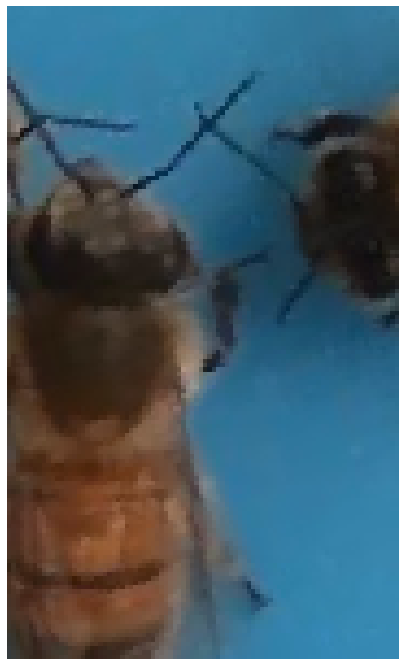

In [122]:
show(X[5])

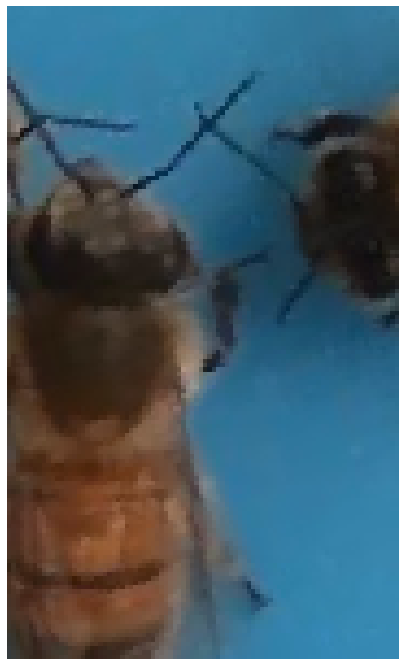

In [162]:
show(X_red[5])

In [163]:
y.shape[0]

714

In [164]:
y.sum()

369

In [165]:
y.sum()/y.shape[0]

0.5168067226890757

In [130]:
X.shape

TensorShape([714, 150, 90, 3])

In [167]:
 from sklearn.model_selection import train_test_split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [188]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [189]:
X_train.shape

(428, 300, 180, 3)

In [190]:
X_train=batch_dim_red(X_train)
X_train.shape

TensorShape([428, 150, 90, 3])

In [191]:
X_val.shape

(143, 300, 180, 3)

In [192]:
X_val=batch_dim_red(X_val)
X_val.shape

TensorShape([143, 150, 90, 3])

In [172]:
X_test.shape

(143, 300, 180, 3)

In [193]:
X_test=batch_dim_red(X_test)
X_test.shape

TensorShape([143, 150, 90, 3])

In [220]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[150, 90, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=2, activation='softmax'),
])

In [221]:

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 150, 90, 64)       1792      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 75, 45, 64)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 75, 45, 128)       73856     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 75, 45, 128)       147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 37, 22, 128)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 37, 22, 256)       295168    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 37, 22, 256)     

In [229]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=[X_val, y_val])


Train on 428 samples, validate on 143 samples
Epoch 1/10
428/428 [==============================] - 3s 6ms/sample - loss: 0.0947 - accuracy: 0.9907 - val_loss: 0.5748 - val_accuracy: 0.9510
Epoch 2/10
428/428 [==============================] - 1s 3ms/sample - loss: 0.0330 - accuracy: 0.9860 - val_loss: 0.8780 - val_accuracy: 0.9371
Epoch 3/10
428/428 [==============================] - 1s 3ms/sample - loss: 0.0515 - accuracy: 0.9907 - val_loss: 0.4906 - val_accuracy: 0.9510
Epoch 4/10
428/428 [==============================] - 1s 3ms/sample - loss: 0.0159 - accuracy: 0.9977 - val_loss: 0.7189 - val_accuracy: 0.9580
Epoch 5/10
428/428 [==============================] - 1s 3ms/sample - loss: 0.0036 - accuracy: 0.9977 - val_loss: 0.5188 - val_accuracy: 0.9650
Epoch 6/10
428/428 [==============================] - 1s 3ms/sample - loss: 0.0042 - accuracy: 0.9977 - val_loss: 1.3875 - val_accuracy: 0.9580
Epoch 7/10
428/428 [==============================] - 1s 3ms/sample - loss: 0.0535 - accur

In [230]:
# Not normalized
score = model.evaluate(X_test, y_test)

143/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [264]:
indices=[1,25,100,110,125]

In [267]:
y_test[:10]

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1])

In [269]:
X_new = X_test[:10]

In [270]:
y_pred = model.predict(X_new)

In [293]:
y_pred.shape

(10, 2)

In [291]:
y_pred[5]

array([1.945025e-24, 1.000000e+00], dtype=float32)

In [299]:

for i in range(0, y_pred.shape[0]):
    if y_pred[i][0]>y_pred[i][1]:
        print(0)
    else:
        print(1)

0
0
0
0
0
1
0
1
0
1


array([1.0000000e+00, 1.3817629e-08], dtype=float32)

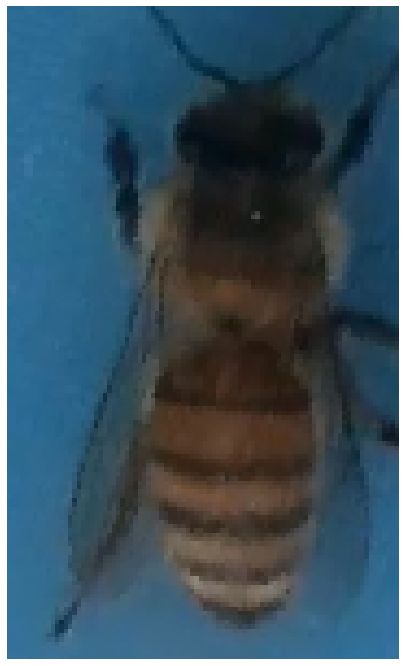

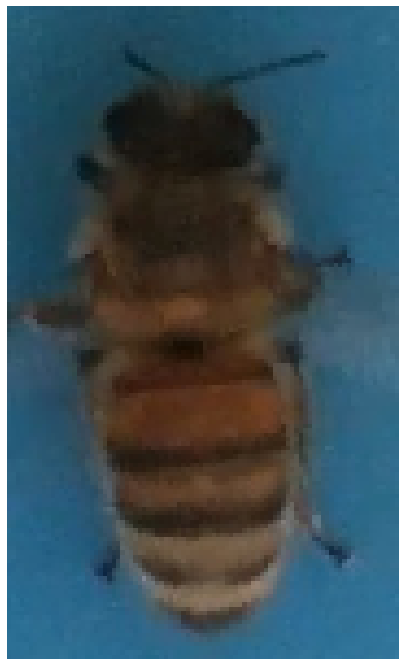

In [304]:
#True Negative
show(X_new[0])
show(X_new[1])

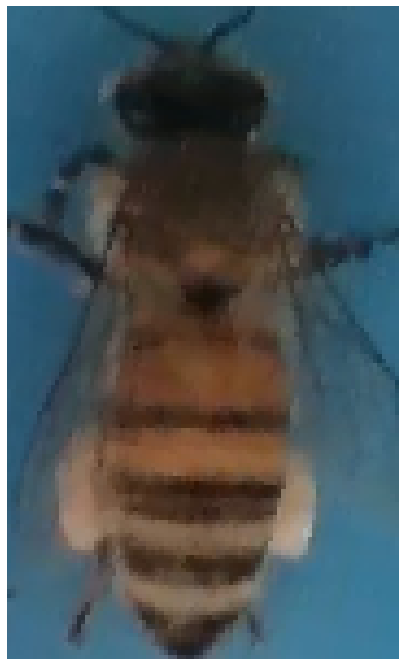

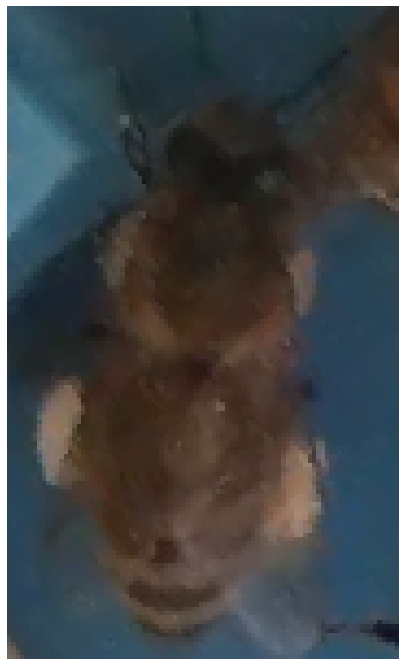

In [305]:
#True Positive
show(X_new[9])
show(X_new[7])

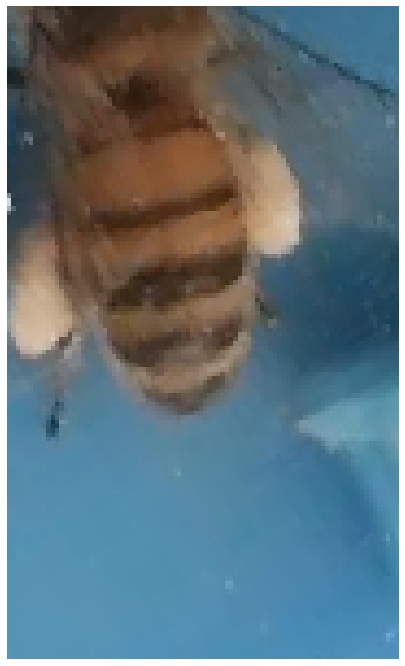

In [302]:
#False Negative
show(X_new[4])

In [307]:
y_pred[4]

array([1.0000000e+00, 1.3817629e-08], dtype=float32)